<center><h1>Unemployment duration with ARIMAX</h1></center>
<center><h2>Kiriel Pena-Navarro</h2></center>
<center><h3>Spring 2024 ECON294A Final Project</h3></center>

### Starting by importing all relevant datasets, and importing packages:

#### Importing packages:

In [86]:
#import packages:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt

## 1. Importing data:

#### Unemployment duration data:

In [87]:
u_d = pd.read_excel('data/UeMPMEAN.xls') #unemployment duration data: measured in average weeks unemployed, monthly frequency

#### Labor force participation data:

In [88]:
lf_p = pd.read_csv("data/CIVPART.csv")
lf_p

,DATE,CIVPART
0,1948-01-01,58.6
1,1948-02-01,58.9
2,1948-03-01,58.5
3,1948-04-01,59.0
4,1948-05-01,58.3
...,...,...
912,2024-01-01,62.5
913,2024-02-01,62.5
914,2024-03-01,62.7
915,2024-04-01,62.7


#### Real Gross Private Domestic Investment (Billions of Chained 2017 dollars, seasonally adjusted annual rate, quarterly)

In [89]:
i = pd.read_csv("data/GPDIC1.csv")
i

,DATE,GPDIC1
0,1947-01-01,227.242
1,1947-04-01,209.836
2,1947-07-01,203.662
3,1947-10-01,243.072
4,1948-01-01,268.012
...,...,...
304,2023-01-01,3963.689
305,2023-04-01,4014.121
306,2023-07-01,4111.053
307,2023-10-01,4118.672


#### U-rate, Population (level), Real GDP, Labor Productivity (output/hour, nonfarm sector), Real wage (16 yrs and older) median weekly earnings, Real personal consumption expenditures per capita - all from FRED

In [90]:
f_data = pd.read_csv("data/fredgraph.csv") #quarterly data
f_data

,DATE,UNRATE,CNP16OV,GDPC1,OPHNFB,LES1252881600Q,A794RX0Q048SBEA
0,1947-01-01,.,.,2182.681,22.265,.,9441.0
1,1947-04-01,.,.,2176.892,22.771,.,9555.0
2,1947-07-01,.,.,2172.432,22.074,.,9542.0
3,1947-10-01,.,.,2206.452,23.002,.,9501.0
4,1948-01-01,3.7333333333333333,102690.666666666667,2239.682,23.106,.,9510.0
...,...,...,...,...,...,...,...
305,2023-04-01,3.5666666666666667,266620.666666666667,22225.35,109.631,365,45811.0
306,2023-07-01,3.7000000000000000,267214.333333333333,22490.692,110.863,366,46094.0
307,2023-10-01,3.7333333333333333,267818.333333333333,22679.255,111.827,371,46400.0
308,2024-01-01,3.8000000000000000,267711.666666666667,22749.846,111.889,365,46576.0


#### Average weekly hours worked for all workers (nonfarm business sector)

In [91]:
h = pd.read_csv('data\PRS85006023.csv')
h

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Kiriel\AppData\Local\Temp\ipykernel_11236\4011778069.py:1: SyntaxWarning: invalid escape sequence '\P'
  h = pd.read_csv('data\PRS85006023.csv')


,DATE,PRS85006023
0,1947-01-01,117.916
1,1947-04-01,117.410
2,1947-07-01,116.869
3,1947-10-01,117.081
4,1948-01-01,117.239
...,...,...
304,2023-01-01,98.934
305,2023-04-01,98.426
306,2023-07-01,98.390
307,2023-10-01,98.025


## 2. Cleaning and preparing datasets:

#### Unemployment data

In [92]:
u_duration = u_d
u_duration = u_duration.iloc[10:,:] #can get rid of first two rows
u_duration.columns = ['Quarter','UEMP'] #renaming columns
#converting data to numeric and date time type:
u_duration = u_duration.infer_objects() #inferred correctly
#u_duration["Month"] = pd.to_datetime(u_duration["Month"], format='%Y-%m-%d')
u_duration.dtypes #datetime and float types
u_duration.set_index('Quarter', inplace=True)
#resample to quarterly (start), using average for quarterly values:
u_duration = u_duration.resample('QS').mean()
u_duration

,UEMP
Quarter,
1948-01-01,8.666667
1948-04-01,8.800000
1948-07-01,8.633333
1948-10-01,8.466667
1949-01-01,8.266667
...,...
2023-04-01,20.900000
2023-07-01,20.800000
2023-10-01,21.133333


#### Labor Force participation data

In [93]:
lf_participation = lf_p
lf_participation["DATE"] = pd.to_datetime(lf_participation["DATE"], format='%Y-%m-%d') #convert dates to datetime
#CIVPART is float so don't have to convert, but will rename:
lf_participation = lf_participation.rename(columns = {"DATE": 'Quarter', 'CIVPART':'LF Rate'}) 
lf_participation.set_index('Quarter', inplace=True) #set index
lf_participation.dtypes #correct types
#resampling to quarterly:
lf_participation = lf_participation.resample('QS').mean()
lf_participation

,LF Rate
Quarter,
1948-01-01,58.666667
1948-04-01,58.833333
1948-07-01,59.033333
1948-10-01,58.833333
1949-01-01,58.866667
...,...
2023-04-01,62.600000
2023-07-01,62.733333
2023-10-01,62.666667


#### Investment

In [94]:
investment = i
investment["DATE"] = pd.to_datetime(investment["DATE"], format='%Y-%m-%d') #covnert to datetime
investment = investment.rename(columns={'DATE': "Quarter", 'GPDIC1':"Real Investment"}) #rename columns
investment.set_index('Quarter',inplace = True)#setting index
investment

,Real Investment
Quarter,
1947-01-01,227.242
1947-04-01,209.836
1947-07-01,203.662
1947-10-01,243.072
1948-01-01,268.012
...,...
2023-01-01,3963.689
2023-04-01,4014.121
2023-07-01,4111.053


#### Fred data

In [95]:
fred_data = f_data #quarterly data
# A794RX0Q048SBEA is consumption, LES1252881600Q is real earnings, OPHNFB is productivity, GDPC1 is real gdp, CNP16OV is population, UNRATE is U-rate
col_names = ['Quarter', 'U-rate', 'Population', 'rGDP', 'Productivity', 'Real earnings', 'Consumption']
fred_data.columns = col_names
fred_data.dtypes #all string/object types so have to convert:
fred_data.replace('.', pd.NA, inplace=True)
fred_data.dropna(inplace=True)
#converting to numeric
for i in range(6):
    fred_data[col_names[i+1]] = fred_data[col_names[i+1]].apply(pd.to_numeric)
fred_data.dtypes #data is now numeric (except for the dates)
fred_data['Quarter'] = pd.to_datetime(fred_data['Quarter'], format='%Y-%m-%d') #convert to datetime
#set the index to quarter:
fred_data = fred_data.set_index('Quarter')
fred_data

,U-rate,Population,rGDP,Productivity,Real earnings,Consumption
Quarter,,,,,,
1979-01-01,5.866667,163756.333333,7238.727,49.633,335,20026.0
1979-04-01,5.700000,164447.333333,7246.454,49.542,335,19961.0
1979-07-01,5.866667,165199.666667,7300.281,49.481,330,20094.0
1979-10-01,5.966667,166054.666667,7318.535,49.422,326,20082.0
1980-01-01,6.300000,166762.333333,7341.557,49.657,321,19997.0
...,...,...,...,...,...,...
2023-01-01,3.500000,266115.333333,22112.329,108.750,363,45772.0
2023-04-01,3.566667,266620.666667,22225.350,109.631,365,45811.0
2023-07-01,3.700000,267214.333333,22490.692,110.863,366,46094.0


In [96]:
fred_data.dtypes

U-rate           float64
Population       float64
rGDP             float64
Productivity     float64
Real earnings      int64
Consumption      float64
dtype: object

#### Hours worked

In [97]:
hours = h 
#convert DATE column to datetime and then set it as index:
hours['DATE'] = pd.to_datetime(hours['DATE'], format='%Y-%m-%d')
hours = hours.rename(columns={"DATE": 'Quarter', 'PRS85006023': 'WHRS'})
hours.set_index('Quarter', inplace=True)
hours

,WHRS
Quarter,
1947-01-01,117.916
1947-04-01,117.410
1947-07-01,116.869
1947-10-01,117.081
1948-01-01,117.239
...,...
2023-01-01,98.934
2023-04-01,98.426
2023-07-01,98.390


## 3. Merging the datasets:

- merging unemployment with LF data:

In [98]:
u_lf = pd.merge(u_duration, lf_participation, on='Quarter')
u_lf

,UEMP,LF Rate
Quarter,,
1948-01-01,8.666667,58.666667
1948-04-01,8.800000,58.833333
1948-07-01,8.633333,59.033333
1948-10-01,8.466667,58.833333
1949-01-01,8.266667,58.866667
...,...,...
2023-04-01,20.900000,62.600000
2023-07-01,20.800000,62.733333
2023-10-01,21.133333,62.666667


- merging previous dataset with real Investment:

In [99]:
ulf_i = pd.merge(u_lf, investment, on='Quarter')
ulf_i

,UEMP,LF Rate,Real Investment
Quarter,,,
1948-01-01,8.666667,58.666667,268.012
1948-04-01,8.800000,58.833333,284.598
1948-07-01,8.633333,59.033333,287.514
1948-10-01,8.466667,58.833333,273.765
1949-01-01,8.266667,58.866667,232.885
...,...,...,...
2023-01-01,19.733333,62.500000,3963.689
2023-04-01,20.900000,62.600000,4014.121
2023-07-01,20.800000,62.733333,4111.053


- merging with fred data

In [100]:
fred_merged = pd.merge(ulf_i, fred_data, on='Quarter')
fred_merged 

,UEMP,LF Rate,Real Investment,U-rate,Population,rGDP,Productivity,Real earnings,Consumption
Quarter,,,,,,,,,
1979-01-01,11.333333,63.733333,1014.607,5.866667,163756.333333,7238.727,49.633,335,20026.0
1979-04-01,10.833333,63.433333,1013.693,5.700000,164447.333333,7246.454,49.542,335,19961.0
1979-07-01,10.466667,63.666667,996.622,5.866667,165199.666667,7300.281,49.481,330,20094.0
1979-10-01,10.633333,63.766667,978.943,5.966667,166054.666667,7318.535,49.422,326,20082.0
1980-01-01,10.666667,63.900000,972.248,6.300000,166762.333333,7341.557,49.657,321,19997.0
...,...,...,...,...,...,...,...,...,...
2023-01-01,19.733333,62.500000,3963.689,3.500000,266115.333333,22112.329,108.750,363,45772.0
2023-04-01,20.900000,62.600000,4014.121,3.566667,266620.666667,22225.350,109.631,365,45811.0
2023-07-01,20.800000,62.733333,4111.053,3.700000,267214.333333,22490.692,110.863,366,46094.0


- finally merging with hours worked dataset:

In [101]:
merged_data = pd.merge(fred_merged, hours, on='Quarter')
merged_data

,UEMP,LF Rate,Real Investment,U-rate,Population,rGDP,Productivity,Real earnings,Consumption,WHRS
Quarter,,,,,,,,,,
1979-01-01,11.333333,63.733333,1014.607,5.866667,163756.333333,7238.727,49.633,335,20026.0,105.648
1979-04-01,10.833333,63.433333,1013.693,5.700000,164447.333333,7246.454,49.542,335,19961.0,105.050
1979-07-01,10.466667,63.666667,996.622,5.866667,165199.666667,7300.281,49.481,330,20094.0,105.370
1979-10-01,10.633333,63.766667,978.943,5.966667,166054.666667,7318.535,49.422,326,20082.0,105.348
1980-01-01,10.666667,63.900000,972.248,6.300000,166762.333333,7341.557,49.657,321,19997.0,104.791
...,...,...,...,...,...,...,...,...,...,...
2023-01-01,19.733333,62.500000,3963.689,3.500000,266115.333333,22112.329,108.750,363,45772.0,98.934
2023-04-01,20.900000,62.600000,4014.121,3.566667,266620.666667,22225.350,109.631,365,45811.0,98.426
2023-07-01,20.800000,62.733333,4111.053,3.700000,267214.333333,22490.692,110.863,366,46094.0,98.390


## 4. Model data setup

#### going to be using 'merged_data'

In [102]:
merged_data.head()

,UEMP,LF Rate,Real Investment,U-rate,Population,rGDP,Productivity,Real earnings,Consumption,WHRS
Quarter,,,,,,,,,,
1979-01-01,11.333333,63.733333,1014.607,5.866667,163756.333333,7238.727,49.633,335,20026.0,105.648
1979-04-01,10.833333,63.433333,1013.693,5.700000,164447.333333,7246.454,49.542,335,19961.0,105.050
1979-07-01,10.466667,63.666667,996.622,5.866667,165199.666667,7300.281,49.481,330,20094.0,105.370
1979-10-01,10.633333,63.766667,978.943,5.966667,166054.666667,7318.535,49.422,326,20082.0,105.348
1980-01-01,10.666667,63.900000,972.248,6.300000,166762.333333,7341.557,49.657,321,19997.0,104.791


#### Forecasting the exogenous variables

- Because SARIMAX requires exogenous variables to have data for forecasting Y, first the exogeneous variables must be forecasted (5 years by choice)

In [103]:
#defining some model parameters:
order = (1,1,1)
sea_order = (1,1,1,4) #4 since quarterly 
steps = 20 #5 years in quarters :D
merged_forecast_data = merged_data.copy() #data to add forecast to
print(len(merged_forecast_data))
print(len(merged_data))
#our exogeneous variables are (everything but UEMP):
covariates = ['LF Rate','Real Investment','U-rate','Population','rGDP','Productivity','Real earnings','Consumption','WHRS']
#fitting each variable individually:
for variable in covariates: #for each variable, fit a model and forecast it
    sarimax_model = SARIMAX(merged_data[variable], order=order, seasonal_order=sea_order)
    variable_fit = sarimax_model.fit()
    forecast = variable_fit.forecast(steps=steps) #getting the forecast results
    to_append = pd.DataFrame(forecast) #creating the forecast data into an 'appendable' dataframe
    to_append.columns = [variable] #renaming the column appropriatelys
    if (len(merged_forecast_data) == len(merged_data)): #if the dataset has not had forecasted data added, then append
        merged_forecast_data = pd.concat([merged_forecast_data, to_append]) #now adding the new forecasted observations
    else: #otherwise we just update to fill the missing values for the other variables
        merged_forecast_data.update(to_append)

# variable = covariates[0]
# sarimax_model = SARIMAX(merged_data[variable], order=order, seasonal_order=sea_order)
# variable_fit = sarimax_model.fit()
# forecast = variable_fit.forecast(steps=steps)
# to_append = pd.DataFrame(forecast)
# to_append.columns = [variable]
# merged_forecast_data = pd.concat([merged_forecast_data, to_append])
# print(to_append)
# print(forecast) 

merged_forecast_data

c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


181
181


c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible st

,UEMP,LF Rate,Real Investment,U-rate,Population,rGDP,Productivity,Real earnings,Consumption,WHRS
1979-01-01,11.333333,63.733333,1014.607000,5.866667,163756.333333,7238.727000,49.633000,335.000000,20026.000000,105.648000
1979-04-01,10.833333,63.433333,1013.693000,5.700000,164447.333333,7246.454000,49.542000,335.000000,19961.000000,105.050000
1979-07-01,10.466667,63.666667,996.622000,5.866667,165199.666667,7300.281000,49.481000,330.000000,20094.000000,105.370000
1979-10-01,10.633333,63.766667,978.943000,5.966667,166054.666667,7318.535000,49.422000,326.000000,20082.000000,105.348000
1980-01-01,10.666667,63.900000,972.248000,6.300000,166762.333333,7341.557000,49.657000,321.000000,19997.000000,104.791000
...,...,...,...,...,...,...,...,...,...,...
2028-01-01,NaN,62.239245,4345.006176,3.452580,274129.847910,24420.771130,117.735998,368.198669,49338.800935,97.291311
2028-04-01,NaN,62.116879,4346.345368,3.770570,274619.702205,24397.253695,118.252793,368.880037,49339.354900,97.227803
2028-07-01,NaN,62.154349,4374.751463,3.554543,275199.929230,24643.592238,118.705196,368.604989,49686.092538,97.207022
2028-10-01,NaN,62.123664,4396.792027,3.421535,275791.576267,24785.281100,119.018045,368.740642,49866.659720,97.242383


#### Plot the forecasted and original covariates - 5 year forecast

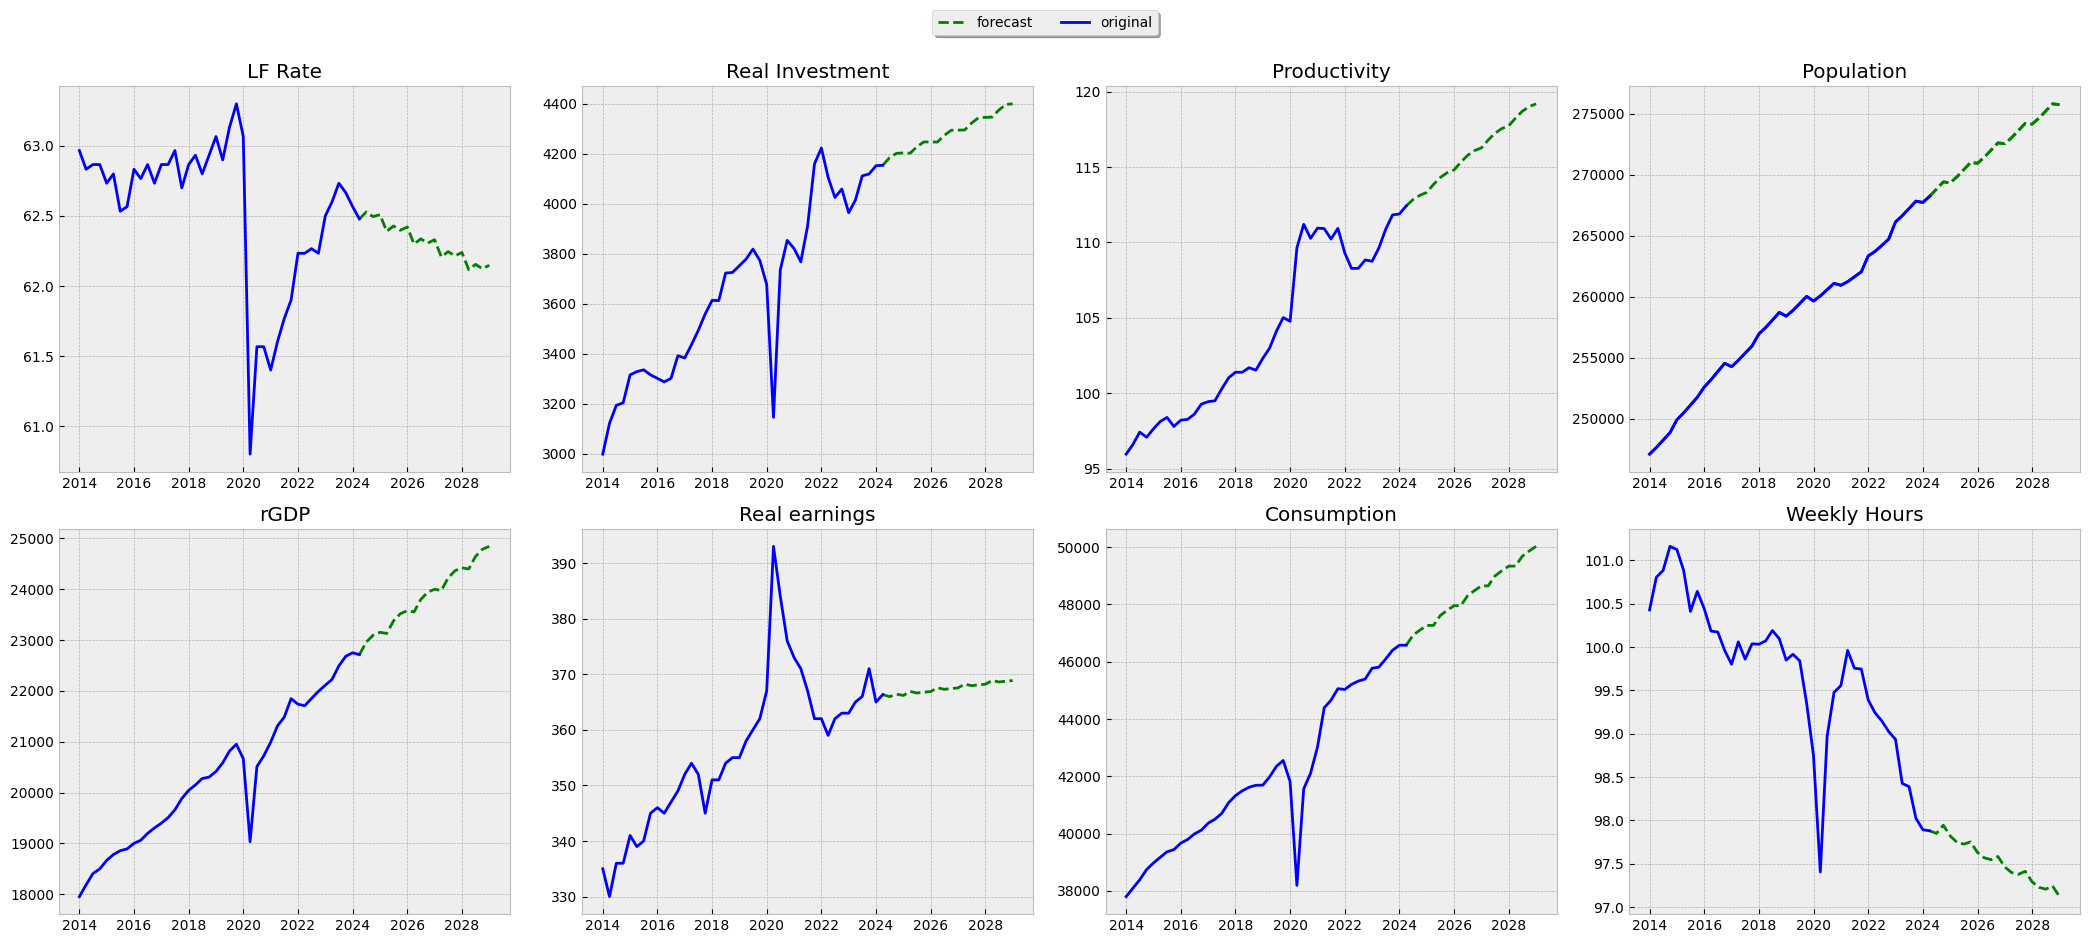

In [104]:
#plotting forecast data and only original data from 2014 to show more recent data and show more of the forecast pattern
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(21, 9))
plt.style.use('bmh')
axes[0,0].plot(merged_forecast_data['LF Rate'].iloc[-20:], color='green', linestyle='dashed', label='forecast') #forecasted data
axes[0,0].plot(merged_forecast_data['LF Rate'].iloc[140:-19], color='blue', label='original') #original data
axes[0,0].set_title('LF Rate')

axes[0,1].plot(merged_forecast_data['Real Investment'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[0,1].plot(merged_forecast_data['Real Investment'].iloc[140:-19], color='blue')
axes[0,1].set_title('Real Investment')

axes[0,2].plot(merged_forecast_data['Productivity'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[0,2].plot(merged_forecast_data['Productivity'].iloc[140:-19], color='blue')
axes[0,2].set_title('Productivity')

axes[0,3].plot(merged_forecast_data['Population'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[0,3].plot(merged_forecast_data['Population'].iloc[140:-19], color='blue')
axes[0,3].set_title('Population')

axes[0,3].plot(merged_forecast_data['Population'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[0,3].plot(merged_forecast_data['Population'].iloc[140:-19], color='blue')
axes[0,3].set_title('Population')

axes[1,0].plot(merged_forecast_data['rGDP'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[1,0].plot(merged_forecast_data['rGDP'].iloc[140:-19], color='blue')
axes[1,0].set_title('rGDP')

axes[1,1].plot(merged_forecast_data['Real earnings'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[1,1].plot(merged_forecast_data['Real earnings'].iloc[140:-19], color='blue')
axes[1,1].set_title('Real earnings')

axes[1,2].plot(merged_forecast_data['Consumption'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[1,2].plot(merged_forecast_data['Consumption'].iloc[140:-19], color='blue')
axes[1,2].set_title('Consumption')

axes[1,3].plot(merged_forecast_data['WHRS'].iloc[-20:], color='green', linestyle='dashed') #forecasted data
axes[1,3].plot(merged_forecast_data['WHRS'].iloc[140:-19], color='blue')
axes[1,3].set_title('Weekly Hours')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), shadow=True, ncol=2)  # Adjust parameters as needed
plt.tight_layout()
plt.savefig('plot1.pdf', dpi=300, bbox_inches='tight')

#### Creating lagged variables and adding to the working dataset:

In [105]:
#I think it makes most sense to lag the unemployment rate, lf rate, investment and consumption for now:
#going to lag a full year (4 quarters):
merged_forecast_data['LF_l'] = merged_forecast_data['LF Rate'].shift(periods=4)
merged_forecast_data['Urate_l'] = merged_forecast_data['U-rate'].shift(periods=4)
merged_forecast_data['Cons_l'] = merged_forecast_data['Consumption'].shift(periods=4)
merged_forecast_data['Invest_l'] = merged_forecast_data['Real Investment'].shift(periods=4)
#now can get rid of the first row/quarter since won't be used in model fit:
merged_forecast_data = merged_forecast_data.iloc[4:,:] #getting rid of missing data but not the ones we want to keep (future UEMP data)

merged_forecast_data

,UEMP,LF Rate,Real Investment,U-rate,Population,rGDP,Productivity,Real earnings,Consumption,WHRS,LF_l,Urate_l,Cons_l,Invest_l
1980-01-01,10.666667,63.900000,972.248000,6.300000,166762.333333,7341.557000,49.657000,321.000000,19997.000000,104.791000,63.733333,5.866667,20026.000000,1014.607000
1980-04-01,11.200000,63.800000,889.579000,7.333333,167415.666667,7190.289000,49.139000,315.000000,19492.000000,103.943000,63.433333,5.700000,19961.000000,1013.693000
1980-07-01,12.366667,63.700000,830.866000,7.666667,168110.666667,7181.743000,49.334000,319.000000,19647.000000,103.762000,63.666667,5.866667,20094.000000,996.622000
1980-10-01,13.466667,63.700000,908.306000,7.400000,168693.666667,7315.677000,49.835000,315.000000,19858.000000,104.254000,63.766667,5.966667,20082.000000,978.943000
1981-01-01,14.133333,63.966667,992.376000,7.433333,169279.000000,7459.022000,50.603000,314.000000,19884.000000,104.382000,63.900000,6.300000,19997.000000,972.248000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2028-01-01,NaN,62.239245,4345.006176,3.452580,274129.847910,24420.771130,117.735998,368.198669,49338.800935,97.291311,62.330372,3.532761,48648.566853,4294.049923
2028-04-01,NaN,62.116879,4346.345368,3.770570,274619.702205,24397.253695,118.252793,368.880037,49339.354900,97.227803,62.208025,3.850751,48649.120792,4294.540269
2028-07-01,NaN,62.154349,4374.751463,3.554543,275199.929230,24643.592238,118.705196,368.604989,49686.092538,97.207022,62.245502,3.634724,48995.858399,4322.134598
2028-10-01,NaN,62.123664,4396.792027,3.421535,275791.576267,24785.281100,119.018045,368.740642,49866.659720,97.242383,62.214816,3.501716,49176.425562,4343.393153


## 5. SARIMAX model:

#### Fitting the model

In [106]:
#setting Y and X:
Y = merged_forecast_data['UEMP'].iloc[:-20] #not including the 'forecast' quarters
X = merged_forecast_data.iloc[:-20,1:] #also not including the earlier forecasted data

sea_order = (1,0,0,4) #4 because of quarterly data, 0 and 0 because it seemd to give lower AIC score than other combinations
order = (1,1,1)
#setting seasonal order to 4 because it is quarterly data, also including constant and linear trend componenet
sarimax = SARIMAX(endog=Y, exog=X, order=order, seasonal_order=sea_order, trend='ct') 
results = sarimax.fit()
print(results.summary())

c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               UEMP   No. Observations:                  177
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 4)   Log Likelihood                -245.601
Date:                            Sat, 15 Jun 2024   AIC                            529.202
Time:                                    12:54:16   BIC                            589.442
Sample:                                01-01-1980   HQIC                           553.635
                                     - 01-01-2024                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.0115      0.027      0.427      0.669      -0.041       0.065
drift           -9.3

c:\Users\Kiriel\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### plotting different components of the unemployment duration series:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


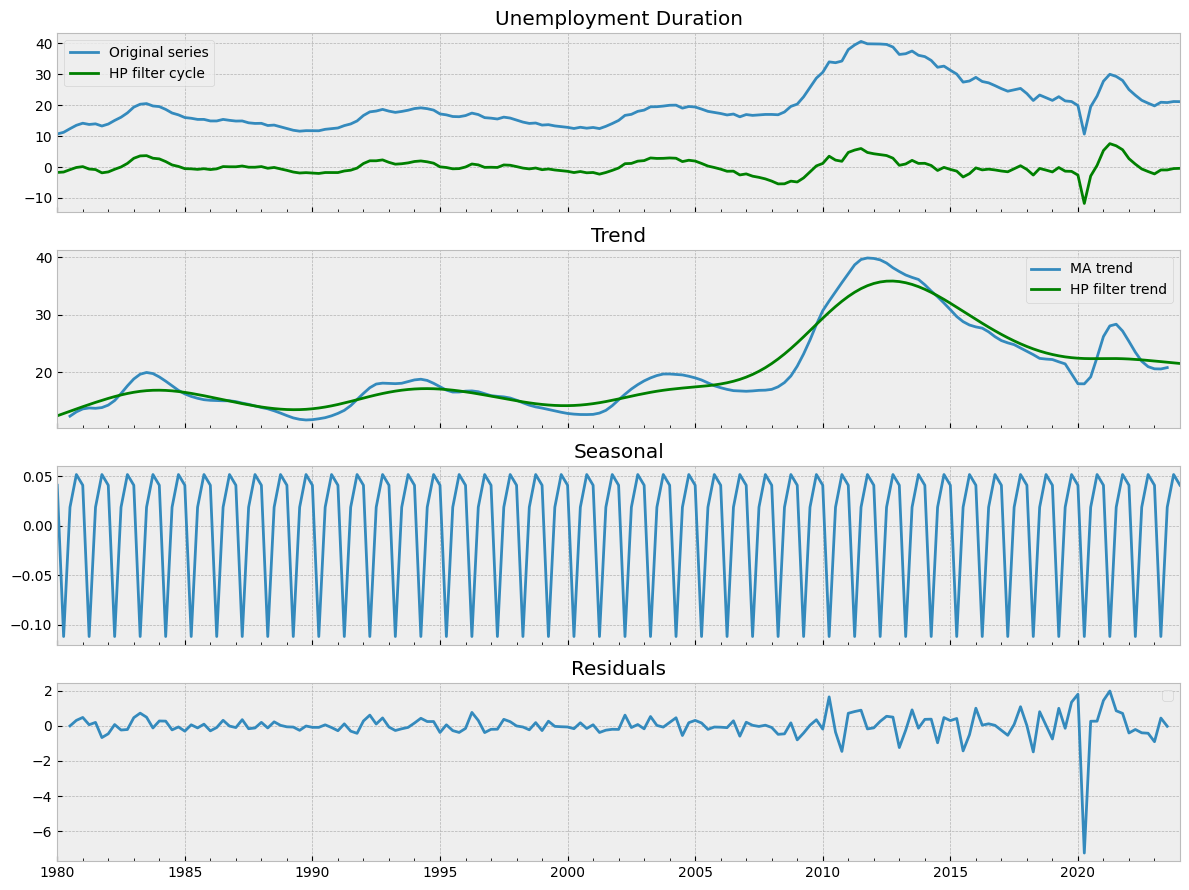

In [107]:
components = seasonal_decompose(Y) #changing options doesn't really do much
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 9), sharex=True)
plt.style.use('bmh')
components.observed.plot(ax=axes[0], title='Unemployment Duration',label='Original series')
components.trend.plot(ax=axes[1], title='Trend', label='MA trend') #trend seems to just be the original series but smoothed
plt.legend()
components.seasonal.plot(ax=axes[2], title='Seasonal')
components.resid.plot(ax=axes[3], title='Residuals')

#using HP filter for trend and cycle:
cycle, trend = hpfilter(Y, 1600)
cycle.plot(ax=axes[0], color='green', label='HP filter cycle')
axes[0].legend()
trend.plot(ax=axes[1], color='green', label='HP filter trend')
axes[1].legend()
plt.tight_layout()
plt.savefig('plot2.pdf', dpi=300, bbox_inches='tight')

#### Forecasting Unemployment duration

In [108]:
forecast = results.forecast(steps=20, exog=merged_forecast_data.iloc[-20:,1:]) #using the earlier forecasted exogeneous variables
#updating the merged dataset with the forecast results:
#update_y = pd.DataFrame(forecast) #creating the forecast data into an 'appendable' dataframe
# update_y.columns = ['UEMP']
# print(merged_forecast_data.update(update_y))
# forecast
#print(pd.DataFrame(forecast))
df = pd.DataFrame(forecast)
df.columns = ['UEMP']
merged_forecast_data.update(df)

#### Plotting the forecast

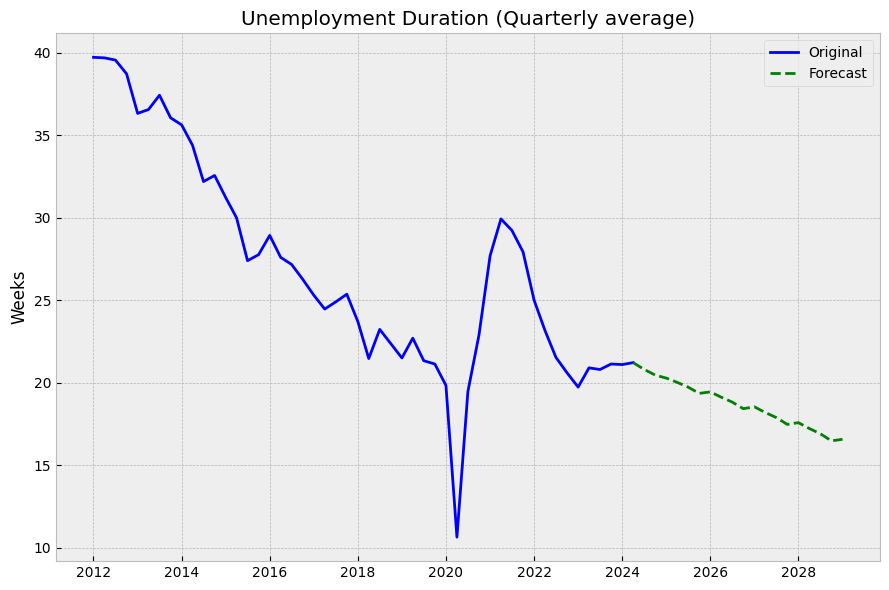

In [109]:
#fig, axes = plt.subplots(1, 1, figsize=(12,9))

# Levels
# axes[0].plot( merged_data['UEMP'], '-')
# axes[0].set(title='U.S. Unemployment duration (average weeks)')
#plt.plot(Y.iloc[156:], label='original', color='blue')

#results.forecast(steps=4).plot(ax=axes[1])
plt.figure(figsize=(9, 6))  
plt.style.use('bmh')
plt.plot(merged_forecast_data["UEMP"].iloc[128:-19], color='blue', label='Original')
plt.plot(merged_forecast_data["UEMP"].iloc[-20:], color='green', linestyle='dashed', label='Forecast')
plt.ylabel('Weeks')
plt.title('Unemployment Duration (Quarterly average)')
plt.tight_layout()
plt.legend()
plt.savefig('plot3.pdf', dpi=300, bbox_inches='tight')
#merged_forecast_data
